In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
import numpy as np
import arviz as az
from scipy import stats
from matplotlib.lines import Line2D
from IPython.display import Image
from graphviz import Digraph


WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


ModuleNotFoundError: No module named 'graphviz'

## Balloon Analogue Risk Task
In this assignment you are given a dataset from an experiment on the risk taking behavior of humans. The task in the experiment is the Balloon Analogue Risk Task (BART). Participants are presented with virtual balloons through a computer screen. Inflating a balloon increases the amount of reward a participant gets, but they need to stop and cash-in before the balloon bursts. If the balloon bursts, then the offered reward is not added to the total. The goal is to maximize the total reward (see this [video](https://www.youtube.com/watch?v=foy3ZVokjFM) for an example). In this experiment, however, there are balloons of different colors: red, blue, and green. The experiment is designed such that at each trial the program draws an integer from a discrete uniform distribution, which defines the number of pumps at which the balloon will burst at that trial. Distributions for each color is as follows:
$$
maxPump_{red} \sim \text{discreteUniform}(1,16)
\\
maxPump_{green} \sim \text{discreteUniform}(1,32)
\\
maxPump_{blue} \sim \text{discreteUniform}(1,64)
$$
Have a look at the first few rows of the dataset below. For participant #1 we can follow the sequence: the first balloon was blue, and the participant pumped it 20 times, and then cahsed-in without a burst, leading to a gain of 20*5=100 points (i.e. reward). Then it was a green balloon, the subject tried to pump it but the balloon burst at the very first step, so the total was the same. It was the same for the next, the red one. It was followed by a blue balloon with 29 pumps, no burst, 145 gain, leading to total 100+145=245. The green one that followed was pumped 5 times, but at the $6^{th}$ pump it burst.

In [59]:
d = pd.read_csv('BART_data.csv')
d.head()

subjectId  trialNum  color  nPump  burst  gain  total
0          1         1   blue     20      0   100    100
1          1         2  green      0      1     0    100
2          1         3    red      0      1     0    100
3          1         4   blue     29      0   145    245
4          1         5  green      5      1     0    245

# Data Overview 

**a.** What are the total scores for each participant? Draw a scatter plot where x-axis is the participant ID (number) and the y-axis is the total score. Draw a horizontal line for the average score across all participants. Your output should look like the one below:


In [7]:
Image('output1.png')

In [17]:
d_1 = d[d['trialNum'] == 30]
x = d_1['subjectId']
y = d_1['total']
y_mean = [np.mean(y) for i in y]



fig, ax = plt.subplots()
ax.set(xlim=(0, 11), xticks=np.arange(1, 13))
ax.scatter(x, y, alpha=0.8)
mean_line = plt.plot(x,y_mean, label='Mean', linestyle='--')
plt.xlabel('participant ID')
plt.ylabel('total score')
plt.show()

**b.** What are the average gain amounts from a trial for each subject? Draw a similar plot where this time the y-axis is the gain amount. For each mean point on the graph, include the errorbars representing the standard error. Be careful, do not to discard trials in which the balloons burst. Use standardized values. Draw the mean gain from a trial, across all participants, as a horizontal line. 
> Standard error of the mean: $\sigma_{\bar{x}}=\frac{\sigma}{\sqrt{n}}$ where n is the sample size and $\sigma$ is the standard deviation.

Your output should like the one below:

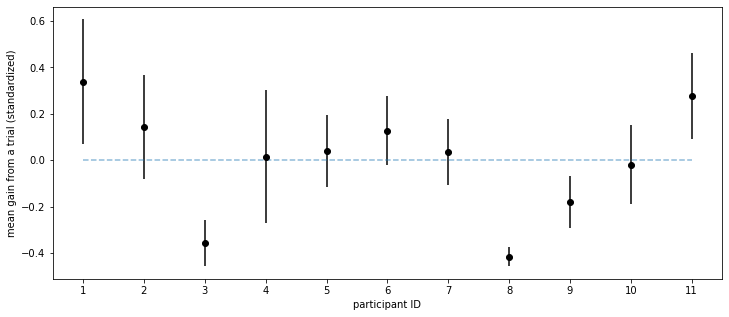

In [9]:
Image('output2.png')

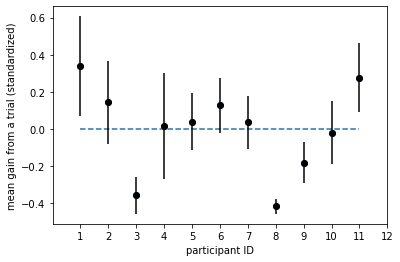

In [15]:
#Lets standardized the data
d['gain_stand'] = (d.gain-d.gain.mean())/d.gain.std()

gain_average = [0]*11
standard_error = [0]*11

for i in range(1,12):
    d_2 = d[d['subjectId'] == i]
    gain_average[i-1] = d_2.gain_stand.mean()
    standard_error[i-1] = d_2.gain_stand.std()/ np.sqrt(30)
    

x = d_1['subjectId']
y = gain_average
y_mean = [np.mean(y) for i in y]
fig, ax = plt.subplots()
plt.scatter(x, y, alpha=0.8)
ax.set(xlim=(0, 11), xticks=np.arange(1, 13))
mean_line = plt.plot(x,y_mean, label='Mean', linestyle='--')
plt.errorbar(x, y, yerr=standard_error, fmt="o",color="black")
plt.xlabel('participant ID')
plt.ylabel('mean gain from a trial (standardized)')
plt.show()
    
   


**c.** Now consider the balloon color. Find the amount of average gain for each color that contributes to the total score, for each participant. Also draw the standard error of those means, for each participant and for each color. Be careful, do not to discard trials in which the balloons burst. Finally, draw the mean contribution of each balloon of different colors, across all participants (i.e three horizontal lines). Use standardized scores. 

In [11]:
Image('output3.png')

In [12]:

gain_average_blue = [0]*11
standard_error_blue = [0]*11

gain_average_green = [0]*11
standard_error_green = [0]*11

gain_average_red = [0]*11
standard_error_red = [0]*11

for i in range(1,12):
    d_2 = d[d['subjectId'] == i]
    d_2_blue = d_2[d_2['color'] == 'blue']
    gain_average_blue[i-1] = d_2_blue.gain_stand.mean()
    standard_error_blue[i-1] = d_2_blue.gain_stand.std()/ np.sqrt(len(d_2_blue))
    
    d_2_green = d_2[d_2['color'] == 'green']
    gain_average_green[i-1] = d_2_green.gain_stand.mean()
    standard_error_green[i-1] = d_2_green.gain_stand.std()/ np.sqrt(len(d_2_green))
    
    d_2_red = d_2[d_2['color'] == 'red']
    gain_average_red[i-1] = d_2_red.gain_stand.mean()
    standard_error_red[i-1] = d_2_red.gain_stand.std()/ np.sqrt(len(d_2_red))
    
    
x = d_1['subjectId']
y_red = gain_average_red
y_blue = gain_average_blue
y_green= gain_average_green

y_mean_red = [np.mean(y_red) for i in y]
y_mean_blue = [np.mean(y_blue) for i in y]
y_mean_green = [np.mean(y_green) for i in y]

fig, ax = plt.subplots()
ax.scatter(x, y_red, alpha=0.9, color="red", label = 'red')
ax.scatter(x, y_green, alpha=0.9, color="green", label = 'green')
ax.scatter(x, y_blue, alpha=0.9, color="blue", label = 'blue')
ax.set(xlim=(0, 11), xticks=np.arange(1, 13))

mean_line = plt.plot(x,y_mean_red, linestyle='--',color="red", alpha=0.3)
plt.errorbar(x, y_red, yerr=standard_error_red, fmt="o",color="red", alpha=0.5, ecolor = 'tomato')

mean_line = plt.plot(x,y_mean_blue, linestyle='--', color="blue", alpha=0.3)
plt.errorbar(x, y_blue, yerr=standard_error_blue, fmt="o", color="blue", alpha=0.7, ecolor = 'lightblue')

mean_line = plt.plot(x,y_mean_green, linestyle='--', color="green", alpha=0.3)
plt.errorbar(x, y_green, yerr=standard_error_green, fmt="o", color="green", alpha=0.7, ecolor = 'lightgreen')

plt.legend()
plt.xlabel('participant ID')
plt.ylabel('mean gain from a trial (standardized)')
plt.show()

# Modeling Gains 

**a.** First, discard the color and implement a Gaussian model for the relation between actor and gain. Use a Gaussian likelihood and assign a unique Gaussian prior for each actor. Create a model with a weak ($\sigma=1.5$) and another with a strong ($\sigma=0.1$) skeptical prior. Assign suitable priors for the model given below.

Weak prior model:

$$
\begin{align*}
{G}_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{A[i]}
\\
\alpha \sim \text{Normal}(0, 1.5)
\\
\sigma \sim \text{Exponential}(1.5)
\end{align*}
$$

In [19]:
# Write your code here (weak prior)
#Model and prior predictive analysis

with pm.Model() as weak:
    a_w = pm.Normal('a_w', 0, 1.5, shape = 11)
    mu_w = a_w[d.subjectId-1]
    sigma_w = pm.Exponential('sigma_w', 1.5)
    g_w = pm.Normal('g_w', mu_w, sigma_w, observed = d.gain_stand)
    trace_weak = pm.sample(1000, tune=1000, chains = 4, return_inferencedata = True)
    prior_pred_model_weak = pm.sample_prior_predictive()   
    
Aseq = np.linspace(1, 11, 11)
fig, ax = plt.subplots(figsize=(5,5))
for i in range(50):
    y = prior_pred_model_weak['a_w'][i,]
    ax.plot(Aseq, y, "r", alpha = 0.4)
    ax.set_ylim(-4, 4)
    ax.set_xlabel("Subject ID")
    ax.set_ylabel("gain (standardized)")    
    
    

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_w, a_w]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [21]:
summary_weak = az.summary(trace_weak)
summary_weak

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_w[0]   0.336  0.179   0.013    0.679      0.003    0.002    4633.0   
a_w[1]   0.143  0.178  -0.182    0.475      0.003    0.002    4246.0   
a_w[2]  -0.349  0.179  -0.686   -0.019      0.003    0.002    4708.0   
a_w[3]   0.016  0.178  -0.311    0.354      0.002    0.003    5125.0   
a_w[4]   0.040  0.176  -0.289    0.374      0.002    0.003    5457.0   
a_w[5]   0.124  0.178  -0.202    0.465      0.003    0.002    4609.0   
a_w[6]   0.037  0.177  -0.310    0.368      0.003    0.003    4882.0   
a_w[7]  -0.411  0.181  -0.748   -0.071      0.003    0.002    5217.0   
a_w[8]  -0.180  0.177  -0.487    0.180      0.002    0.002    5345.0   
a_w[9]  -0.015  0.179  -0.355    0.322      0.003    0.003    3955.0   
a_w[10]  0.273  0.173  -0.049    0.599      0.003    0.002    4452.0   
sigma_w  0.990  0.039   0.922    1.069      0.001    0.000    4742.0   

         ess_tail  r_hat  
a_w[0]     3288.0    1.0  
a_w[1]     3211.0    1.0  
a_w[2]     3055.0    1.0  
a_w[3]     3217.0    1.0  
a_w[4]     3270.0    1.0  
a_w[5]     3187.0    1.0  
a_w[6]     2961.0    1.0  
a_w[7]     3043.0    1.0  
a_w[8]     3126.0    1.0  
a_w[9]     2932.0    1.0  
a_w[10]    3332.0    1.0  
sigma_w    3258.0    1.0

In [22]:
az.plot_trace(trace_weak, compact=False)

array([[<AxesSubplot:title={'center':'a_w\n0'}>,
        <AxesSubplot:title={'center':'a_w\n0'}>],
       [<AxesSubplot:title={'center':'a_w\n1'}>,
        <AxesSubplot:title={'center':'a_w\n1'}>],
       [<AxesSubplot:title={'center':'a_w\n2'}>,
        <AxesSubplot:title={'center':'a_w\n2'}>],
       [<AxesSubplot:title={'center':'a_w\n3'}>,
        <AxesSubplot:title={'center':'a_w\n3'}>],
       [<AxesSubplot:title={'center':'a_w\n4'}>,
        <AxesSubplot:title={'center':'a_w\n4'}>],
       [<AxesSubplot:title={'center':'a_w\n5'}>,
        <AxesSubplot:title={'center':'a_w\n5'}>],
       [<AxesSubplot:title={'center':'a_w\n6'}>,
        <AxesSubplot:title={'center':'a_w\n6'}>],
       [<AxesSubplot:title={'center':'a_w\n7'}>,
        <AxesSubplot:title={'center':'a_w\n7'}>],
       [<AxesSubplot:title={'center':'a_w\n8'}>,
        <AxesSubplot:title={'center':'a_w\n8'}>],
       [<AxesSubplot:title={'center':'a_w\n9'}>,
        <AxesSubplot:title={'center':'a_w\n9'}>],
       [<A

Strong prior model:

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{A[i]}
\\
\alpha_s \sim \text{Normal}(0, 0.1)
\\
\sigma_s \sim \text{Exponential}(0.1)
\end{align*}
$$

In [24]:
# Write your code here (strong prior)
#Model and prior predictive analysis
with pm.Model() as strong:
    a_s = pm.Normal('a_s',0, 0.1, shape=11)
    mu_s = a_s[d.subjectId-1]
    sigma_s = pm.Exponential('sigma_s', 0.1)
    g_s = pm.Normal('g_s', mu_s, sigma_s, observed = d.gain_stand)
    trace_strong = pm.sample(1000, tune=1000, chains = 4, return_inferencedata = True)
    prior_pred_model_strong = pm.sample_prior_predictive() 
    
Aseq = np.linspace(1, 11, 11)
fig, ax = plt.subplots(figsize=(5,5))
for i in range(50):
    y = prior_pred_model_strong['a_s'][i,]
    ax.plot(Aseq, y, "r", alpha = 0.4) 
    ax.set_ylim(-4, 4)
    ax.set_xlabel("Subject ID")
    ax.set_ylabel("gain (standardized)")        

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_s, a_s]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.


In [25]:
summary_strong = az.summary(trace_strong)
summary_strong

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_s[0]   0.079  0.087  -0.088    0.242      0.001    0.001    4542.0   
a_s[1]   0.034  0.083  -0.115    0.196      0.001    0.001    5628.0   
a_s[2]  -0.082  0.086  -0.243    0.077      0.001    0.001    5185.0   
a_s[3]   0.003  0.086  -0.157    0.164      0.001    0.001    4731.0   
a_s[4]   0.009  0.087  -0.154    0.175      0.001    0.001    4839.0   
a_s[5]   0.030  0.089  -0.131    0.200      0.001    0.001    4984.0   
a_s[6]   0.009  0.088  -0.153    0.178      0.001    0.001    4911.0   
a_s[7]  -0.096  0.087  -0.251    0.074      0.001    0.001    5622.0   
a_s[8]  -0.044  0.087  -0.214    0.111      0.001    0.001    5753.0   
a_s[9]  -0.005  0.088  -0.163    0.167      0.001    0.001    5846.0   
a_s[10]  0.064  0.088  -0.105    0.225      0.001    0.001    4864.0   
sigma_s  0.995  0.040   0.922    1.072      0.001    0.000    5863.0   

         ess_tail  r_hat  
a_s[0]     2892.0    1.0  
a_s[1]     3349.0    1.0  
a_s[2]     3112.0    1.0  
a_s[3]     3278.0    1.0  
a_s[4]     2808.0    1.0  
a_s[5]     3318.0    1.0  
a_s[6]     3058.0    1.0  
a_s[7]     3287.0    1.0  
a_s[8]     3416.0    1.0  
a_s[9]     3327.0    1.0  
a_s[10]    2962.0    1.0  
sigma_s    2937.0    1.0

array([[<AxesSubplot:title={'center':'a_s\n0'}>,
        <AxesSubplot:title={'center':'a_s\n0'}>],
       [<AxesSubplot:title={'center':'a_s\n1'}>,
        <AxesSubplot:title={'center':'a_s\n1'}>],
       [<AxesSubplot:title={'center':'a_s\n2'}>,
        <AxesSubplot:title={'center':'a_s\n2'}>],
       [<AxesSubplot:title={'center':'a_s\n3'}>,
        <AxesSubplot:title={'center':'a_s\n3'}>],
       [<AxesSubplot:title={'center':'a_s\n4'}>,
        <AxesSubplot:title={'center':'a_s\n4'}>],
       [<AxesSubplot:title={'center':'a_s\n5'}>,
        <AxesSubplot:title={'center':'a_s\n5'}>],
       [<AxesSubplot:title={'center':'a_s\n6'}>,
        <AxesSubplot:title={'center':'a_s\n6'}>],
       [<AxesSubplot:title={'center':'a_s\n7'}>,
        <AxesSubplot:title={'center':'a_s\n7'}>],
       [<AxesSubplot:title={'center':'a_s\n8'}>,
        <AxesSubplot:title={'center':'a_s\n8'}>],
       [<AxesSubplot:title={'center':'a_s\n9'}>,
        <AxesSubplot:title={'center':'a_s\n9'}>],
       [<A

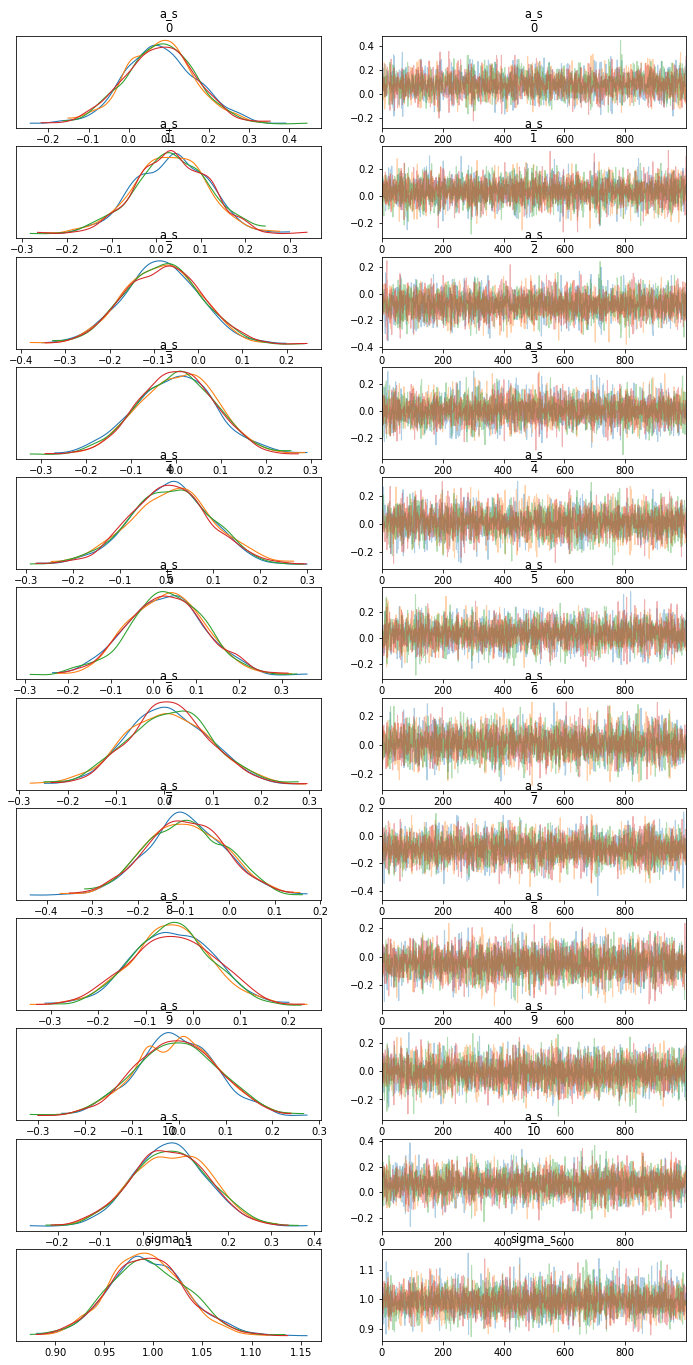

In [26]:
az.plot_trace(trace_strong, compact=False)

**b.** Is it possible to learn the strength of the prior from the data itself? If so, implement an appropriate hierarchical model and compare this model with the two in part *a* in terms of a predictive criterion. It is likely that you'll encounter some problems with this new model (since it is centered). Modify it as necessary (reparameterize to be non-centered). For each actor, plot the estimated means from each model on top of sample means. Use 89% HDI as errorbars on your estimated values. What seems to be the difference between these models. How $\sigma$ value affects model fit? 

Hierarchical version (centered):

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \alpha_{A[i]}
\\
\alpha_j &  \sim \text{Normal} (\bar{\alpha} , \sigma_{a})
\\
\bar{\alpha} &\sim \text{Normal}(0, 1.5)
\\
\sigma_{a}  &\sim\text{Exponential}(1.5)
\\
\sigma    &\sim\text{Exponential}(1.5)
\end{align*}
$$

In [27]:
# Write your code here (centered model)

with pm.Model() as centered:
    a_bar = pm.Normal('a_bar',0, 1.5)
    sigma_a = pm.Exponential('sigma_a', 1.5)
    a = pm.Normal('a', a_bar, sigma_a, shape=11)
    sigma = pm.Exponential('sigma', 1.5)
    mu = a[d.subjectId-1]
    g = pm.Normal('g', mu, sigma, observed = d.gain_stand)
    trace_centered = pm.sample(1000, tune=1000, chains = 4, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, a, sigma_a, a_bar]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.
There were 10 divergences after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 14 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 10% for some parameters.


In [30]:
summary_centered = az.summary(trace_centered, var_names = 'a')
summary_centered

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a[0]   0.152  0.146  -0.123    0.421      0.005    0.003     913.0    2417.0   
a[1]   0.063  0.130  -0.163    0.322      0.003    0.002    2583.0    2420.0   
a[2]  -0.159  0.150  -0.437    0.112      0.005    0.003    1045.0    1878.0   
a[3]   0.005  0.129  -0.240    0.251      0.003    0.002    2154.0    2531.0   
a[4]   0.019  0.130  -0.214    0.278      0.002    0.002    2825.0    2551.0   
a[5]   0.062  0.135  -0.184    0.324      0.003    0.002    1985.0    2377.0   
a[6]   0.017  0.129  -0.221    0.273      0.003    0.002    1859.0    2504.0   
a[7]  -0.185  0.155  -0.462    0.109      0.005    0.003    1039.0    1451.0   
a[8]  -0.078  0.136  -0.335    0.170      0.003    0.002    1985.0    2291.0   
a[9]  -0.005  0.128  -0.232    0.258      0.002    0.002    2751.0    2542.0   
a[10]  0.126  0.142  -0.135    0.386      0.005    0.003     888.0     677.0   

       r_hat  
a[0]     1.0  
a[1]     1.0  
a[2]     1.0  
a[3]     1.0  
a[4]     1.0  
a[5]     1.0  
a[6]     1.0  
a[7]     1.0  
a[8]     1.0  
a[9]     1.0  
a[10]    1.0

In [31]:
az.summary(trace_centered)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
a_bar    0.003  0.083  -0.152    0.155      0.002    0.002    1298.0   
a[0]     0.152  0.146  -0.123    0.421      0.005    0.003     913.0   
a[1]     0.063  0.130  -0.163    0.322      0.003    0.002    2583.0   
a[2]    -0.159  0.150  -0.437    0.112      0.005    0.003    1045.0   
a[3]     0.005  0.129  -0.240    0.251      0.003    0.002    2154.0   
a[4]     0.019  0.130  -0.214    0.278      0.002    0.002    2825.0   
a[5]     0.062  0.135  -0.184    0.324      0.003    0.002    1985.0   
a[6]     0.017  0.129  -0.221    0.273      0.003    0.002    1859.0   
a[7]    -0.185  0.155  -0.462    0.109      0.005    0.003    1039.0   
a[8]    -0.078  0.136  -0.335    0.170      0.003    0.002    1985.0   
a[9]    -0.005  0.128  -0.232    0.258      0.002    0.002    2751.0   
a[10]    0.126  0.142  -0.135    0.386      0.005    0.003     888.0   
sigma_a  0.177  0.087   0.037    0.324      0.004    0.003     297.0   
sigma    0.992  0.039   0.915    1.062      0.001    0.001    2748.0   

         ess_tail  r_hat  
a_bar      2286.0   1.00  
a[0]       2417.0   1.00  
a[1]       2420.0   1.00  
a[2]       1878.0   1.00  
a[3]       2531.0   1.00  
a[4]       2551.0   1.00  
a[5]       2377.0   1.00  
a[6]       2504.0   1.00  
a[7]       1451.0   1.00  
a[8]       2291.0   1.00  
a[9]       2542.0   1.00  
a[10]       677.0   1.00  
sigma_a     176.0   1.01  
sigma      2594.0   1.00

array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a\n0'}>,
        <AxesSubplot:title={'center':'a\n0'}>],
       [<AxesSubplot:title={'center':'a\n1'}>,
        <AxesSubplot:title={'center':'a\n1'}>],
       [<AxesSubplot:title={'center':'a\n2'}>,
        <AxesSubplot:title={'center':'a\n2'}>],
       [<AxesSubplot:title={'center':'a\n3'}>,
        <AxesSubplot:title={'center':'a\n3'}>],
       [<AxesSubplot:title={'center':'a\n4'}>,
        <AxesSubplot:title={'center':'a\n4'}>],
       [<AxesSubplot:title={'center':'a\n5'}>,
        <AxesSubplot:title={'center':'a\n5'}>],
       [<AxesSubplot:title={'center':'a\n6'}>,
        <AxesSubplot:title={'center':'a\n6'}>],
       [<AxesSubplot:title={'center':'a\n7'}>,
        <AxesSubplot:title={'center':'a\n7'}>],
       [<AxesSubplot:title={'center':'a\n8'}>,
        <AxesSubplot:title={'center':'a\n8'}>],
       [<AxesSubplot:title={'center':'a\n9'}>,
 

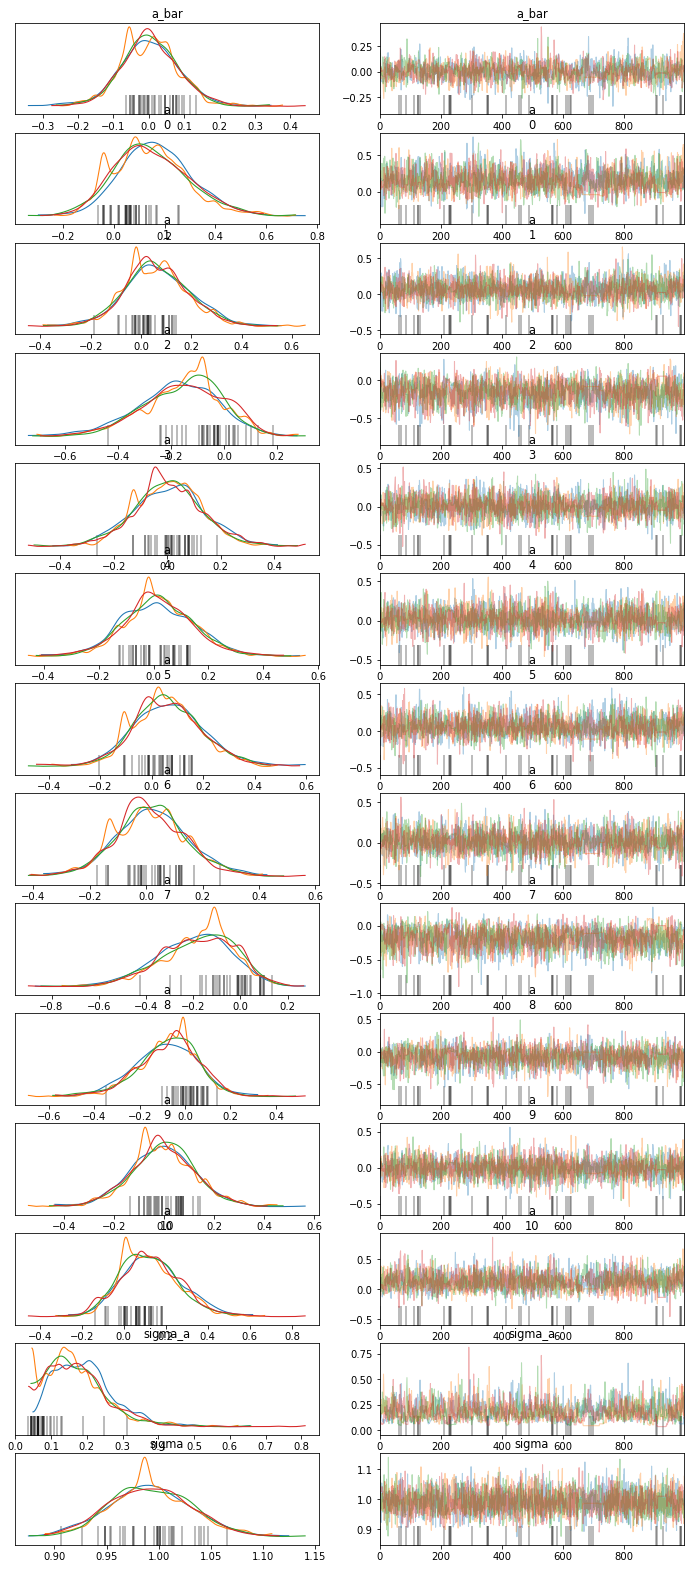

In [32]:
az.plot_trace(trace_centered, compact=False)

Hierarchical version (non-centered):

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \bar \alpha + z_{A[i]} \times \sigma_{a}
\\
\bar \alpha &  \sim \text{Normal}(0 , 1.5)
\\
z_j &  \sim \text{Normal}(0 , 1)
\\ 
\sigma_{a}  &\sim\text{Exponential}(1.5)
\\ 
\sigma  &\sim\text{Exponential}(1.5)
\end{align*}
$$

In [33]:
# Write your code here (non-centered model)
with pm.Model() as non_centered:
    z = pm.Normal('z', 0.0, 1.0, shape = 11)
    a_bar = pm.Normal('a_bar', 0.0, 1.5)
    sigma_a = pm.Exponential('sigma_a', 1.5)
    mu = a_bar + z[d.subjectId-1]*sigma_a
    sigma = pm.Exponential('sigma', 1.5)
    g = pm.Normal('g', mu, sigma, observed = d.gain_stand)
    trace_non_centered = pm.sample(1000, tune=1000, chains = 4, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, sigma_a, a_bar, z]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
There were 24 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.684760726355672, but should be close to 0.8. Try to increase the number of tuning steps.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8830057191219108, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [37]:
summary_non_centered = az.summary(trace_non_centered, var_names= "z")
summary_non_centered

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
z[0]   0.738  0.838  -0.833    2.330      0.019    0.013    1993.0    2020.0   
z[1]   0.313  0.813  -1.253    1.782      0.018    0.014    2080.0    2192.0   
z[2]  -0.832  0.821  -2.479    0.623      0.020    0.015    1771.0    1865.0   
z[3]   0.014  0.793  -1.519    1.471      0.017    0.013    2121.0    2397.0   
z[4]   0.084  0.767  -1.477    1.441      0.018    0.015    1810.0    1817.0   
z[5]   0.271  0.801  -1.216    1.776      0.017    0.014    2217.0    2323.0   
z[6]   0.085  0.804  -1.424    1.652      0.017    0.015    2204.0    1977.0   
z[7]  -0.947  0.836  -2.440    0.750      0.019    0.014    1898.0    1996.0   
z[8]  -0.430  0.797  -2.001    1.030      0.018    0.014    1998.0    2216.0   
z[9]  -0.046  0.773  -1.506    1.417      0.016    0.013    2317.0    2168.0   
z[10]  0.595  0.809  -1.078    2.010      0.018    0.014    1992.0    1960.0   

       r_hat  
z[0]     1.0  
z[1]     1.0  
z[2]     1.0  
z[3]     1.0  
z[4]     1.0  
z[5]     1.0  
z[6]     1.0  
z[7]     1.0  
z[8]     1.0  
z[9]     1.0  
z[10]    1.0

In [38]:
az.summary(trace_non_centered)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z[0]     0.738  0.838  -0.833    2.330      0.019    0.013    1993.0   
z[1]     0.313  0.813  -1.253    1.782      0.018    0.014    2080.0   
z[2]    -0.832  0.821  -2.479    0.623      0.020    0.015    1771.0   
z[3]     0.014  0.793  -1.519    1.471      0.017    0.013    2121.0   
z[4]     0.084  0.767  -1.477    1.441      0.018    0.015    1810.0   
z[5]     0.271  0.801  -1.216    1.776      0.017    0.014    2217.0   
z[6]     0.085  0.804  -1.424    1.652      0.017    0.015    2204.0   
z[7]    -0.947  0.836  -2.440    0.750      0.019    0.014    1898.0   
z[8]    -0.430  0.797  -2.001    1.030      0.018    0.014    1998.0   
z[9]    -0.046  0.773  -1.506    1.417      0.016    0.013    2317.0   
z[10]    0.595  0.809  -1.078    2.010      0.018    0.014    1992.0   
a_bar    0.003  0.076  -0.149    0.143      0.003    0.002     866.0   
sigma_a  0.159  0.094   0.000    0.318      0.003    0.002     822.0   
sigma    0.992  0.041   0.920    1.068      0.001    0.001    1587.0   

         ess_tail  r_hat  
z[0]       2020.0   1.00  
z[1]       2192.0   1.00  
z[2]       1865.0   1.00  
z[3]       2397.0   1.00  
z[4]       1817.0   1.00  
z[5]       2323.0   1.00  
z[6]       1977.0   1.00  
z[7]       1996.0   1.00  
z[8]       2216.0   1.00  
z[9]       2168.0   1.00  
z[10]      1960.0   1.00  
a_bar       614.0   1.01  
sigma_a    1107.0   1.01  
sigma      1647.0   1.01

In [36]:
# Write your code here (model comparison)
az.compare({"centered": trace_centered, "non-centered": trace_non_centered}, ic ="waic", scale = "deviance")

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/stats.py:1635: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


rank        waic     p_waic    d_waic  weight         se  \
centered         0  942.639107  11.063308  0.000000     1.0  62.066699   
non-centered     1  942.967446  10.947088  0.328338     0.0  62.045135   

                   dse  warning waic_scale  
centered      0.000000     True   deviance  
non-centered  0.486131     True   deviance

In [48]:
# Write your code here (plots) [Hint: your plot should look like the one below]

gain_model_1 = [0]*11
gain_model_2 = [0]*11 
gain_model_4 = [0]*11
gain_average = [0]*11


for i in range(0,11):
    
    gain_model_1[i] = summary_weak.iloc[i,0]
    
    gain_model_2[i] = summary_strong.iloc[i,0]
    
    gain_model_4[i] = summary_centered.iloc[i,0]
    
for i in range(1,12):
    d_2 = d[d['subjectId'] == i]
    gain_average[i-1] = d_2.gain_stand.mean()    
    
x = d_1['subjectId']
y_m1 = gain_model_1
y_m2 = gain_model_2
y_m4= gain_model_4
y = gain_average
y_mean = [np.mean(y) for i in y]

fig, ax = plt.subplots()
ax.scatter(x, y, marker="*", color="black", label = "sample")
ax.scatter(x, y_m1, alpha=0.4, color="red", label = 'm1')
ax.scatter(x, y_m2, alpha=0.4, color="green", label = 'm2')
ax.scatter(x, y_m4, alpha=0.4, color="blue", label = 'm4')
ax.set(xlim=(0, 11), xticks=np.arange(1, 13))

mean_line = plt.plot(x,y_mean, label='Mean', linestyle='--')

plt.legend()
plt.xlabel('participant ID')
plt.ylabel('mean gain from a trial (standardized)')
plt.show()    

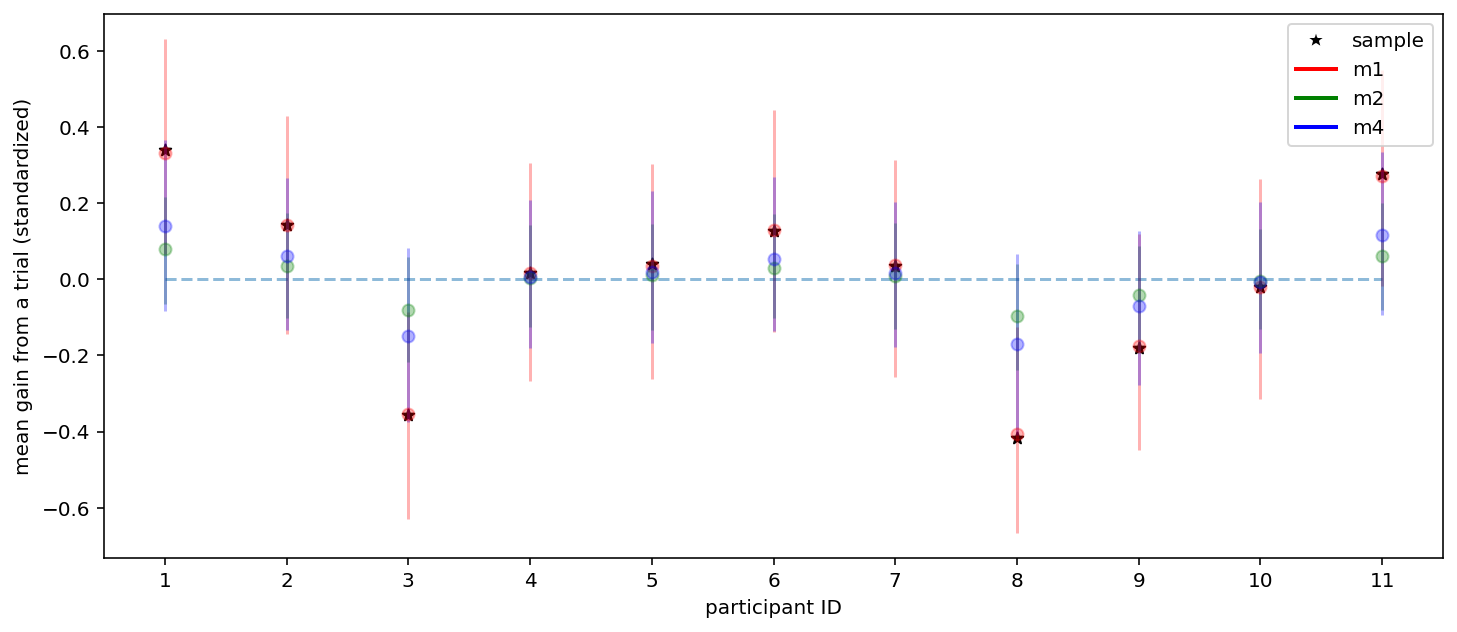

In [20]:
Image('output4.png')

**c.** Note that the experiment has 3 treatments (i.e. 3 different balloon colors). Create a model for the gains, but this time add a term for the treatments (i.e. consider treatments as another cluster). Implement a non-centered version. Plot the posterior distributions for treatment intercepts. How do you interpret them? 

The non-centered model:

$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma)
\\
\mu_i &= \bar{\alpha} +  \text{z}_{A[i]} \times \sigma_{\alpha} + \beta_{T[i]}
\\
\bar \alpha &  \sim \text{Normal}(0 , 1)
\\
z_{a} &  \sim \text{Normal}(0 , 1.5)
\\ 
z_{b} &  \sim \text{Normal}(0 , 1.5)
\\
\sigma_{a}, \sigma_{b}, \sigma_{G}   &\sim\text{Exponential}(1.5)
\end{align*}
$$

In [50]:
# Write your code here (non-centered model)

d["c"]=d['color']
d['c'] = pd.factorize(d['c'])[0]
d.head()

#Here, blue is 0, green is 1 and red is 2

with pm.Model() as color:
    sigma_a = pm.Exponential('sigma_a', 1.5)
    sigma_b = pm.Exponential('sigma_b', 1.5)
    sigma_g = pm.Exponential('sigma_g', 1.5)
    z_a = pm.Normal('z_a', mu = 0, sigma = 1.5, shape=11)
    z_b = pm.Normal('z_b', mu = 0, sigma = 1.5, shape=3)
    a_bar = pm.Normal('_bar', mu = 0, sigma = 1)
    mu = a_bar + z_a[d.subjectId-1] * sigma_a + z_b[d.c] * sigma_b
    g = pm.Normal("g", mu = mu, sigma = sigma_g, observed = d.gain_stand)
    trace_color = pm.sample(1000, tune=2000, chains=4, return_inferencedata = True, target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [_bar, z_b, z_a, sigma_g, sigma_b, sigma_a]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 58 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


In [51]:
# Write your code here (for posterior distributions)
with pm.Model() as color:
    pm.sample_posterior_predictive(trace_color)
    
az.plot_posterior(trace_color ,hdi_prob=0.92, var_names=["z_b"])    

array([<AxesSubplot:title={'center':'z_b\n0'}>,
       <AxesSubplot:title={'center':'z_b\n1'}>,
       <AxesSubplot:title={'center':'z_b\n2'}>], dtype=object)

In [52]:
az.summary(trace_color)

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
z_a[0]   1.416  1.154  -0.838    3.578      0.017    0.015    4843.0   
z_a[1]   0.600  1.113  -1.487    2.685      0.017    0.017    4480.0   
z_a[2]  -1.470  1.127  -3.506    0.862      0.017    0.014    4538.0   
z_a[3]   0.071  1.100  -2.030    2.082      0.015    0.020    5057.0   
z_a[4]   0.166  1.089  -1.866    2.208      0.016    0.018    4837.0   
z_a[5]   0.556  1.126  -1.589    2.697      0.016    0.020    5191.0   
z_a[6]   0.132  1.089  -1.915    2.188      0.016    0.018    4639.0   
z_a[7]  -1.713  1.133  -3.945    0.304      0.017    0.013    4602.0   
z_a[8]  -0.701  1.118  -2.842    1.370      0.016    0.016    4695.0   
z_a[9]  -0.075  1.124  -2.202    2.063      0.016    0.019    4970.0   
z_a[10]  1.147  1.138  -0.835    3.383      0.017    0.016    4636.0   
z_b[0]   1.307  0.988  -0.468    3.230      0.022    0.015    1958.0   
z_b[1]  -0.056  0.813  -1.524    1.534      0.018    0.013    2010.0   
z_b[2]  -1.305  1.002  -3.241    0.413      0.021    0.015    2168.0   
_bar     0.005  0.411  -0.807    0.795      0.010    0.007    1700.0   
sigma_a  0.123  0.059   0.019    0.236      0.002    0.001    1124.0   
sigma_b  0.515  0.290   0.161    1.051      0.007    0.005    1976.0   
sigma_g  0.885  0.036   0.815    0.947      0.001    0.000    4785.0   

         ess_tail  r_hat  
z_a[0]     2566.0    1.0  
z_a[1]     2573.0    1.0  
z_a[2]     2066.0    1.0  
z_a[3]     3091.0    1.0  
z_a[4]     2877.0    1.0  
z_a[5]     2559.0    1.0  
z_a[6]     2805.0    1.0  
z_a[7]     2705.0    1.0  
z_a[8]     2738.0    1.0  
z_a[9]     2754.0    1.0  
z_a[10]    2589.0    1.0  
z_b[0]     1920.0    1.0  
z_b[1]     2432.0    1.0  
z_b[2]     2420.0    1.0  
_bar       1901.0    1.0  
sigma_a    1481.0    1.0  
sigma_b    2101.0    1.0  
sigma_g    2681.0    1.0

array([[<AxesSubplot:title={'center':'z_a\n0'}>,
        <AxesSubplot:title={'center':'z_a\n0'}>],
       [<AxesSubplot:title={'center':'z_a\n1'}>,
        <AxesSubplot:title={'center':'z_a\n1'}>],
       [<AxesSubplot:title={'center':'z_a\n2'}>,
        <AxesSubplot:title={'center':'z_a\n2'}>],
       [<AxesSubplot:title={'center':'z_a\n3'}>,
        <AxesSubplot:title={'center':'z_a\n3'}>],
       [<AxesSubplot:title={'center':'z_a\n4'}>,
        <AxesSubplot:title={'center':'z_a\n4'}>],
       [<AxesSubplot:title={'center':'z_a\n5'}>,
        <AxesSubplot:title={'center':'z_a\n5'}>],
       [<AxesSubplot:title={'center':'z_a\n6'}>,
        <AxesSubplot:title={'center':'z_a\n6'}>],
       [<AxesSubplot:title={'center':'z_a\n7'}>,
        <AxesSubplot:title={'center':'z_a\n7'}>],
       [<AxesSubplot:title={'center':'z_a\n8'}>,
        <AxesSubplot:title={'center':'z_a\n8'}>],
       [<AxesSubplot:title={'center':'z_a\n9'}>,
        <AxesSubplot:title={'center':'z_a\n9'}>],
       [<A

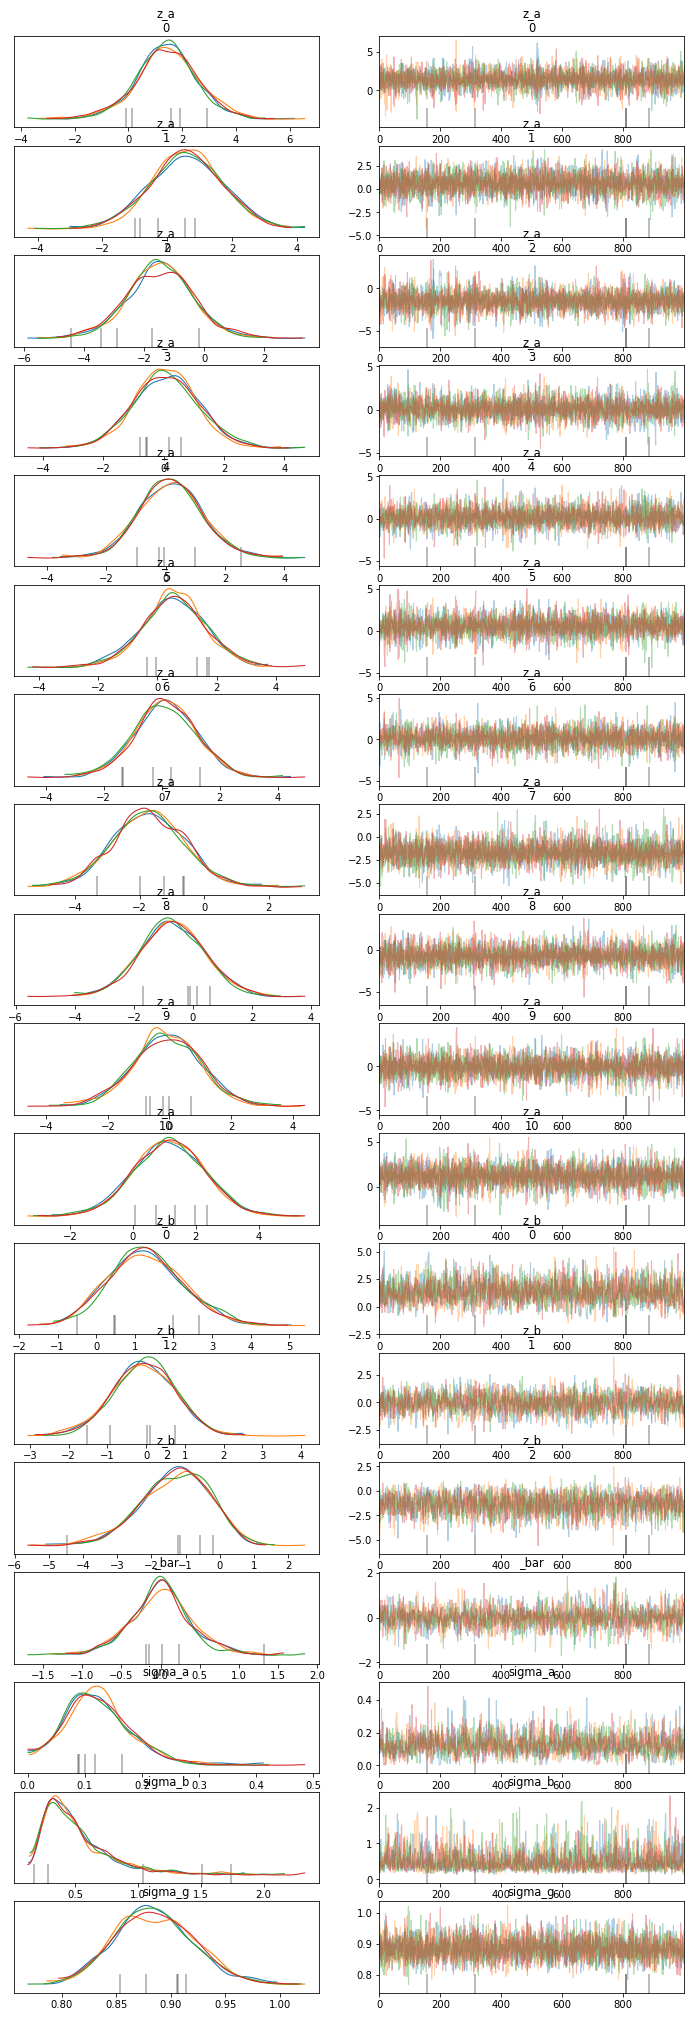

In [53]:
az.plot_trace(trace_color, compact=False)

**d.** When we've plotted the gains for different colors of balloons, we've seen that not all actors are similarly affected by the color treatment. In the previous model we added the treatment term as a single parameter. Now modify your model which can account for the covarying actor-treatment effects. (Hint: you need to use a multivariate normal distribution). In other words, take balloon color to be a feature, rather than a cluster. Again, since the centered version probably will not sample adequately, implement a non-centered version. 
- Plot the estimated mean for each actor, as you did before. How this model, which can account for covariance, is different from the previous model where the treatment effects were not considered at all. Compare the two using a predictive criterion.
- Visualize the estimated covariance term. Plot the sample means for gains from each balloon color, for each participant (as you did before), and plot the estimated means.

The non-centered model:
$$
\begin{align*}
G_i &\sim \text{Normal}(\mu_i, \sigma_{g})
\\
\mu_i &= \bar{\alpha}_{A[i]} +  \alpha_{A[i],T[i]} 
\\ 
\alpha &= (\text{diag}(\pmb S_A) \pmb L_A \pmb Z_{T,A})^T
\\
\pmb Z_{T,A} & \sim \text{Normal}(0,1.5)
\\
z_{\bar A,j} &\sim \text{Normal}(0,1.5)
\\
\bar \alpha &= z_{\bar A,j} \tau_A
\\
S_{A,j}, \tau_A &\sim \text{Exponential}(1.5) \qquad \text{for} \ j \in 1..3
\\ 
\pmb R_A &\sim \text{LKJcorr}(4)
\\
\sigma_{g} &\sim \text{Exponential}(1.5)
\end{align*}
$$

In [56]:
# Write your code here (non-centered model)
with pm.Model() as color_mlv:
    
    sigma = pm.Exponential.dist(1.5)
    chol_actor, _, _ = pm.LKJCholeskyCov("chol_actor", n = 3, eta = 3, sd_dist = sigma, compute_corr = True)
    chol_block, _, _ = pm.LKJCholeskyCov("chol_block", n = 3, eta = 3, sd_dist = sigma, compute_corr = True)

    tau_A = pm.Exponential('tau_A', 1)


    z_A = pm.Normal("z_A", 0, 1, shape = 11)


    a_bar = z_A * tau_A

    sigma_g = pm.Exponential("sigma_g", 1.5)

    z_actor = pm.Normal("z_actor", 0, 1, shape = (3,11))
    a = pm.math.dot(chol_actor, z_actor).T

    
    mu = a_bar[d.subjectId-1] + a[d.subjectId-1, d.c]
    G = pm.Normal("G", mu = mu, sigma = sigma_g, observed = d.gain_stand)
    
    trace_color_mlv = pm.sample(4000, tune = 4000,  target_accept=0.9, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z_actor, sigma_g, z_A, tau_A, chol_block, chol_actor]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 4_000 tune and 4_000 draw iterations (16_000 + 16_000 draws total) took 181 seconds.
The acceptance probability does not match the target. It is 0.807573354062514, but should be close to 0.9. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.7658177972378234, but should be close to 0.9. Try to increase the number of tuning steps.
The number of effective samples is smaller than 10% for some parameters.


In [57]:
az.summary(trace_color_mlv)

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
z_A[0]                 0.306  0.913  -1.441    2.023      0.027    0.019   
z_A[1]                -0.052  0.891  -1.760    1.641      0.013    0.011   
z_A[2]                -0.650  0.929  -2.338    1.120      0.019    0.013   
z_A[3]                -0.091  0.876  -1.826    1.517      0.018    0.013   
z_A[4]                 0.107  0.866  -1.584    1.731      0.010    0.010   
...                      ...    ...     ...      ...        ...      ...   
chol_block_corr[2, 0] -0.011  0.351  -0.627    0.646      0.005    0.004   
chol_block_corr[2, 1]  0.011  0.351  -0.628    0.654      0.007    0.005   
chol_block_corr[2, 2]  1.000  0.000   1.000    1.000      0.000    0.000   
tau_A                  0.116  0.085   0.000    0.262      0.002    0.001   
sigma_g                0.861  0.035   0.797    0.927      0.001    0.001   

                       ess_bulk  ess_tail  r_hat  
z_A[0]                   1182.0    1473.0   1.01  
z_A[1]                   4758.0    4121.0   1.00  
z_A[2]                   2357.0    4076.0   1.00  
z_A[3]                   2238.0    4097.0   1.00  
z_A[4]                   6861.0    5308.0   1.00  
...                         ...       ...    ...  
chol_block_corr[2, 0]    4771.0    4175.0   1.00  
chol_block_corr[2, 1]    3121.0    6477.0   1.00  
chol_block_corr[2, 2]   12331.0   11932.0   1.00  
tau_A                    2361.0    3752.0   1.01  
sigma_g                  1474.0    4403.0   1.00  

[82 rows x 9 columns]

/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/plots/traceplot.py:212: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (82), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'z_A\n0'}>,
        <AxesSubplot:title={'center':'z_A\n0'}>],
       [<AxesSubplot:title={'center':'z_A\n1'}>,
        <AxesSubplot:title={'center':'z_A\n1'}>],
       [<AxesSubplot:title={'center':'z_A\n2'}>,
        <AxesSubplot:title={'center':'z_A\n2'}>],
       [<AxesSubplot:title={'center':'z_A\n3'}>,
        <AxesSubplot:title={'center':'z_A\n3'}>],
       [<AxesSubplot:title={'center':'z_A\n4'}>,
        <AxesSubplot:title={'center':'z_A\n4'}>],
       [<AxesSubplot:title={'center':'z_A\n5'}>,
        <AxesSubplot:title={'center':'z_A\n5'}>],
       [<AxesSubplot:title={'center':'z_A\n6'}>,
        <AxesSubplot:title={'center':'z_A\n6'}>],
       [<AxesSubplot:title={'center':'z_A\n7'}>,
        <AxesSubplot:title={'center':'z_A\n7'}>],
       [<AxesSubplot:title={'center':'z_A\n8'}>,
        <AxesSubplot:title={'center':'z_A\n8'}>],
       [<AxesSubplot:title={'center':'z_A\n9'}>,
        <AxesSubplot:title={'center':'z_A\n9'}>],
       [<A

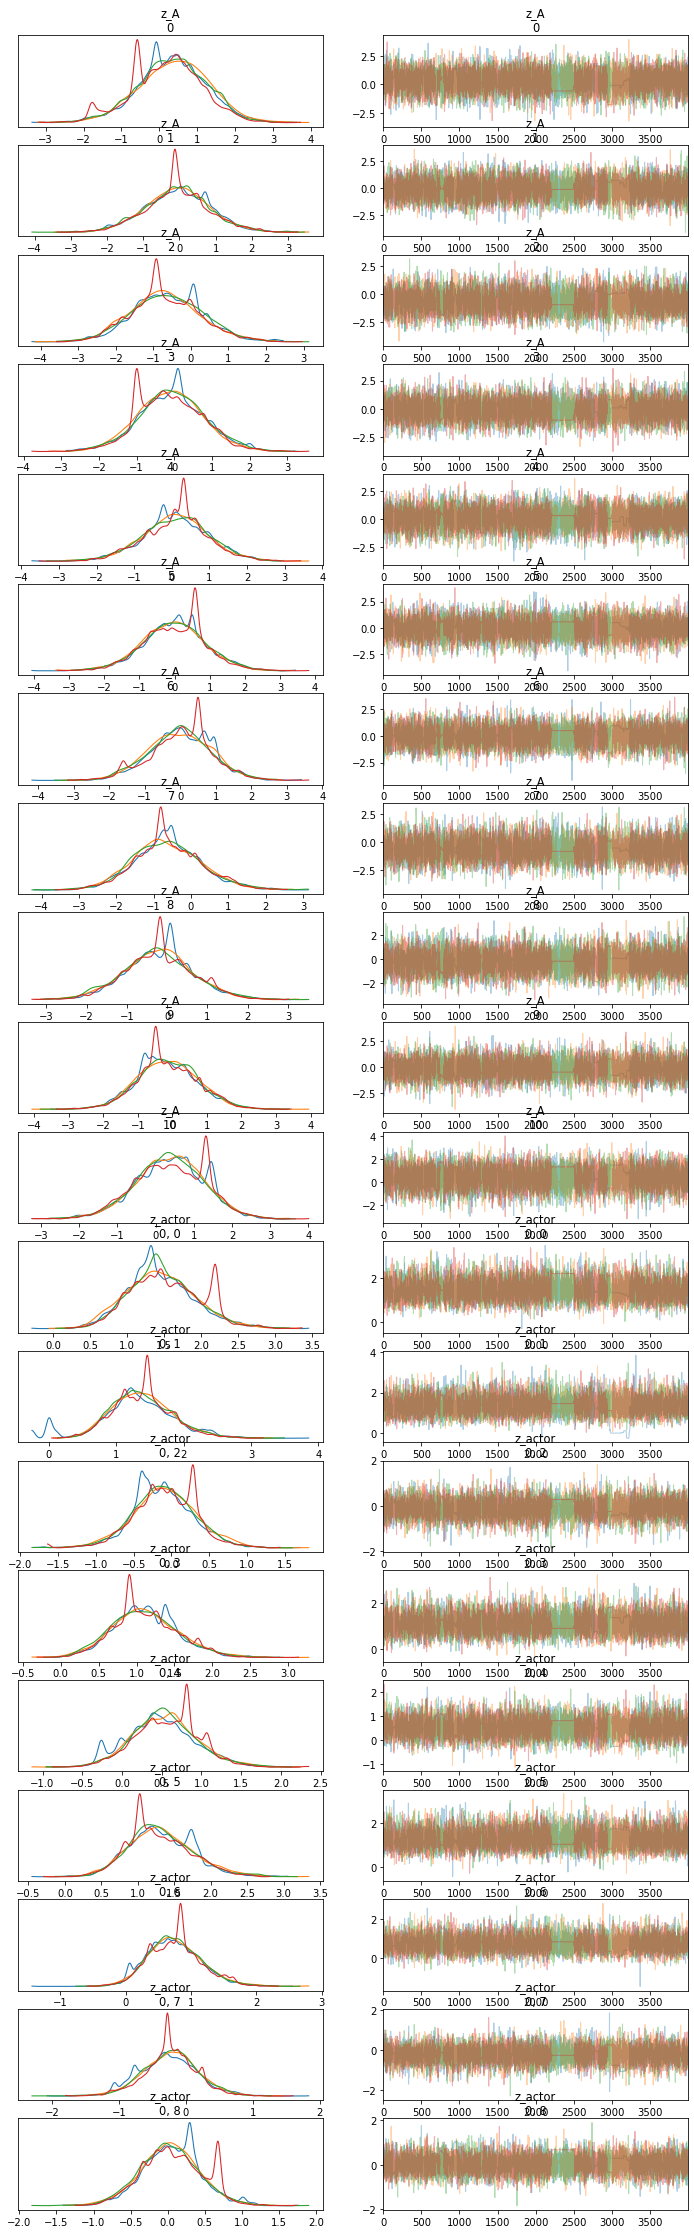

In [58]:
az.plot_trace(trace_color_mlv, compact=False)